In [3]:
mode = "svg"

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

In [4]:
import numpy as np
from graphbook_code import dcsbm

np.random.seed(0)

nk = 150
z = np.repeat([1,2], nk)
B = np.array([[0.6, 0.2], [0.2, 0.4]])
theta = np.tile(6**np.linspace(0, -1, nk), 2)
A, P = dcsbm(z, theta, B, return_prob=True)

In [5]:
from graspologic.embed import AdjacencySpectralEmbed as ase
from scipy.spatial import distance_matrix

d = 2  # the latent dimensionality
# estimate the latent position matrix with ase
Xhat = ase(n_components=d).fit_transform(A)
# compute the distance matrix
D = distance_matrix(Xhat, Xhat)

In [6]:
Xhat_rescaled = Xhat / theta[:,None]
D_rescaled = distance_matrix(Xhat_rescaled, Xhat_rescaled)

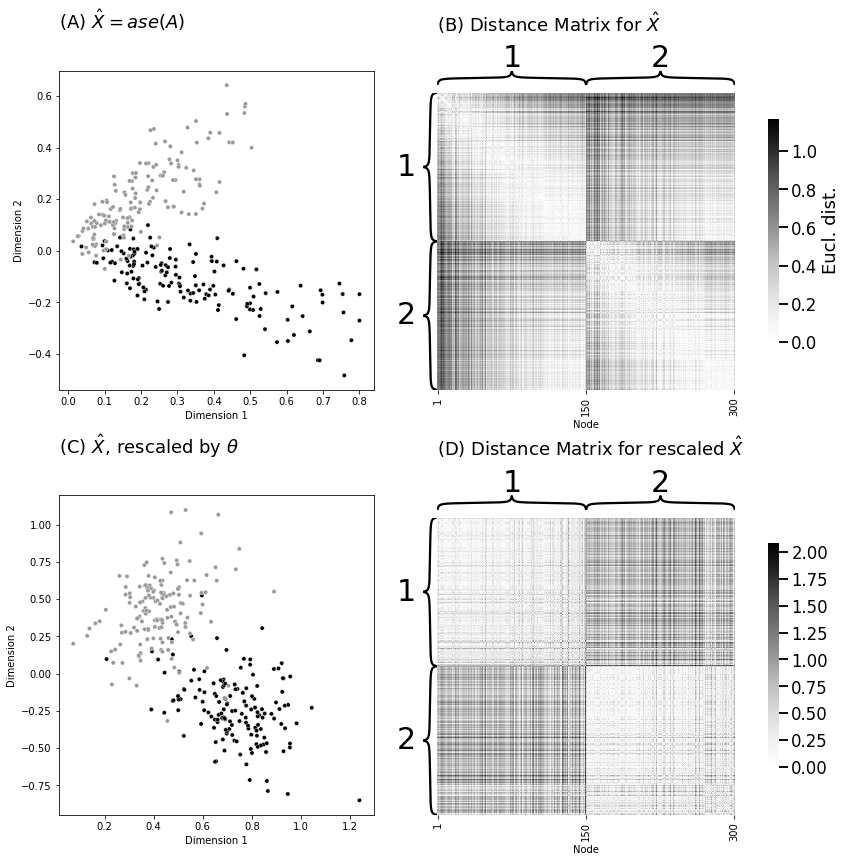

In [7]:
from graphbook_code import heatmap, plot_latents
import os
fig, axs = plt.subplots(2, 2, gridspec_kw={"width_ratios": [1.5, 2]}, figsize=(12, 12))

ax = plot_latents(Xhat, labels=z, title="(A) $\\hat X = ase(A)$", palette={1: "#000000", 2: "#999999"}, 
                  size=5, ax=axs[0][0], legend=False, xtitle="Dimension 1", ytitle="Dimension 2")
ax.set_title("(A) $\\hat X = ase(A)$", pad=42, fontsize=18, loc="left")
heatmap(D, title="(B) Distance Matrix for $\\hat X$", ax=axs[0][1],
        xticks=[0.5, 149.5, 299.5], xticklabels=[1, 150, 300], xtitle="Node",
        inner_hier_labels=z, legend_title="Eucl. dist.")

ax = plot_latents(Xhat_rescaled, labels=z, title="(C) $\\hat X$, rescaled by $\\vec \\theta$", 
                  palette={1: "#000000", 2: "#999999"}, size=5, ax=axs[1][0], legend=False,
                  xtitle="Dimension 1", ytitle="Dimension 2")
ax.set_title("(C) $\\hat X$, rescaled by $\\theta$", pad=42, fontsize=18, loc="left")
heatmap(D_rescaled, title="(D) Distance Matrix for rescaled $\\hat X$", ax=axs[1][1],
        xticks=[0.5, 149.5, 299.5], xticklabels=[1, 150, 300], xtitle="Node",
        inner_hier_labels=z, legend_title="")

fig.tight_layout()

os.makedirs("Figures", exist_ok=True)
fname = "dcsbm_ase"
if mode != "png":
    os.makedirs(f"Figures/{mode:s}", exist_ok=True)
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

os.makedirs("Figures/png", exist_ok=True)
fig.savefig(f"Figures/png/{fname:s}.png")

In [ ]:
from graspologic.embed import LaplacianSpectralEmbed as lse

d = 2  # embed into two dimensions
Xhat_lapl = lse(n_components=d).fit_transform(A)
D_lapl = distance_matrix(Xhat_lapl, Xhat_lapl)

In [ ]:
fig, axs = plt.subplots(2, 2, gridspec_kw={"width_ratios": [1.5, 2]}, figsize=(12, 12))

ax = plot_latents(Xhat, labels=z, title="(A) $\\hat X = ase(A)$", palette={1: "#000000", 2: "#999999"}, size=5, ax=axs[0][0], legend=False,
                 xtitle="Dimension 1", ytitle="Dimension 2")
ax.set_title("(A) $\\hat X = ase(A)$", pad=42, fontsize=18, loc="left")
heatmap(D, title="(B) Distance Matrix for $\\hat X$", ax=axs[0][1],
        xticks=[0.5, 149.5, 299.5], xticklabels=[1, 150, 300], xtitle="Node",
        inner_hier_labels=z, legend_title="Eucl. dist.")

ax = plot_latents(Xhat_lapl, labels=z, title="(C) $\\hat Y = lse(A)$", 
             palette={1: "#000000", 2: "#999999"}, size=5, ax=axs[1][0], legend=False,
                 xtitle="Dimension 1", ytitle="Dimension 2")
ax.set_title("(C) $\\hat Y = lse(A)$", pad=42, fontsize=18, loc="left")
heatmap(D_lapl, title="(D) Distance Matrix for $\\hat Y$", ax=axs[1][1],
        xticks=[0.5, 149.5, 299.5], xticklabels=[1, 150, 300], xtitle="Node",
        inner_hier_labels=z, legend_title="")

fig.tight_layout()

fname = "dcsbm_lse"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [ ]:
import seaborn as sns
import pandas as pd

# compute the degrees for each node, using the
# row-sums of the network
degrees = A.sum(axis = 0)

# plot the degree histogram

df = pd.DataFrame({"Node degree" : degrees, "Community": z})

In [ ]:
from graspologic.simulations import sbm

Asbm = sbm([nk, nk], B)

# row-sums of the network
degrees_sbm = Asbm.sum(axis = 0)
df_sbm = pd.DataFrame({"Node degree" : degrees_sbm, "Community": z})

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=df, x="Node degree", bins=20, color="black", ax=axs[0])
axs[0].set_title("$DCSBM_n(\\vec z, \\vec \\theta, B)$ sample")
axs[0].annotate("Heavy tail", xy=(35, 15), rotation=-25)
axs[0].annotate("", xy=(55, 10), xytext=(30, 25), arrowprops={"arrowstyle": "->"}, rotation=-25)
sns.histplot(data=df_sbm, x="Node degree", bins=20, color="black", ax=axs[1])
axs[1].set_title("$SBM_n(\\vec z, B)$ sample")
axs[1].annotate("No tail", xy=(140, 10), xytext=(140, 15), arrowprops={"arrowstyle": "->"})
axs[1].set_xlim(60, 160)

fig.tight_layout()

fname = "lse_degree"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")